In [1]:
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [2]:
excel_sheet1 = 'Desktop/indicators1.xlsx'
df1 = pd.read_excel(excel_sheet1,sheet_name ='Sheet18')
df2= pd.read_excel(excel_sheet1,sheet_name ='Sheet19')

In [3]:
df = pd.merge(df1,df2,on ='Year',how = 'outer')
df1 =df[::-1]
df1

,Year,"life expectancy at birth,male(years)","life expectancy at birth,female"
61,1960,47.3,50.3
60,1961,48.1,51.1
59,1962,48.8,51.8
58,1963,49.4,52.4
57,1964,49.9,52.9
...,...,...,...
4,2017,60.1,65.0
3,2018,60.3,65.2
2,2019,60.7,65.3
1,2020,60.4,65.1


<Axes: xlabel='Year'>

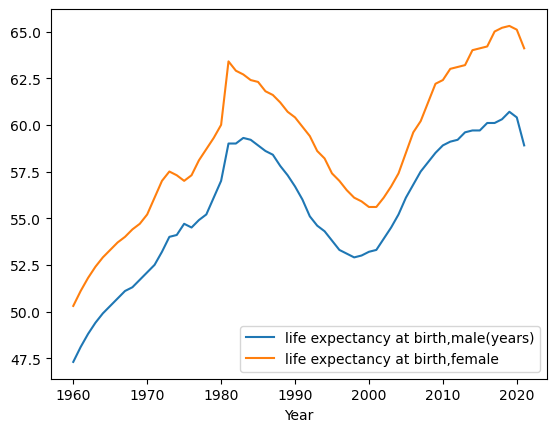

In [4]:
df.plot(x='Year',y=['life expectancy at birth,male(years)','life expectancy at birth,female'])

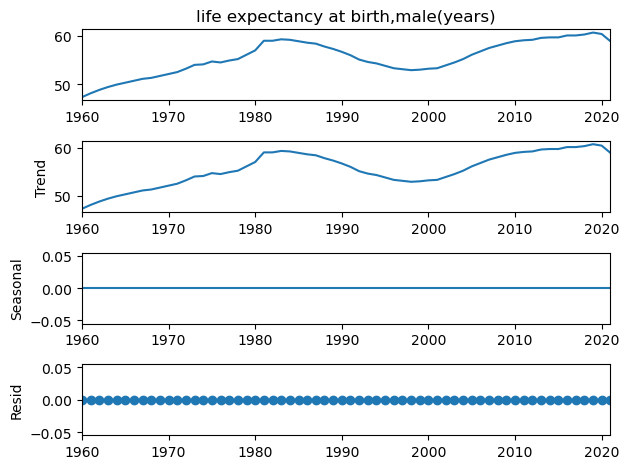

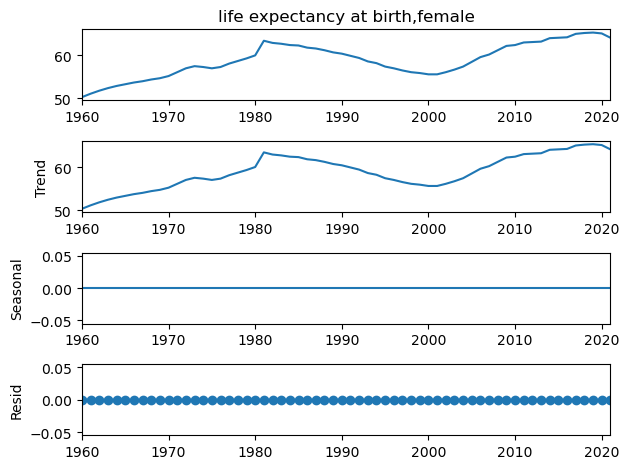

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming your DataFrame is named 'df'
# Convert 'Year' to datetime type
df1['Year'] = pd.to_datetime(df1['Year'], format='%Y')
df1.set_index('Year', inplace=True)

# Decompose the time series for males
result_male = seasonal_decompose(df1['life expectancy at birth,male(years)'], model='additive')

# Decompose the time series for females
result_female = seasonal_decompose(df1['life expectancy at birth,female'], model='additive')

# Plot the decomposed components
result_male.plot()
result_female.plot()
plt.show()


In [6]:
from statsmodels.tsa.stattools import adfuller, kpss

In [7]:
def print_results(output, test='adf'):        
    pval = output[1]    
    test_score = output[0]    
    lags = output[2]        
    decision = 'Non-Stationary'    
    if test == 'adf':        
        critical = output[4]        
        if pval < 0.05:            
            decision = 'Stationary'    
    elif test=='kpss':        
        critical = output[3]        
        if pval >= 0.05:            
            decision = 'Stationary'                
    output_dict = {
                'Test Statistic': test_score,    
                'p-value': pval,    
                'Numbers of lags': lags,    
                'decision': decision
            }    
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value           
        
    return pd.Series(output_dict, name=test)

In [8]:
# Combine differenced columns into a single column for modeling
df2 = df1['life expectancy at birth,male(years)']
# Convert the Series to a DataFrame with a single column
data1 = df2.to_frame(name='life expectancy at birth,male')
# Print the updated DataFrame
print(data1)

            life expectancy at birth,male
Year                                     
1960-01-01                           47.3
1961-01-01                           48.1
1962-01-01                           48.8
1963-01-01                           49.4
1964-01-01                           49.9
...                                   ...
2017-01-01                           60.1
2018-01-01                           60.3
2019-01-01                           60.7
2020-01-01                           60.4
2021-01-01                           58.9

[62 rows x 1 columns]


In [9]:
import warnings
warnings.simplefilter('ignore')

In [10]:
# Test statistics for stationarity
# Run both adf and kpss tests
adf_output = adfuller(data1)
kpss_output = kpss(data1)
pd.concat([
    print_results(adf_output, 'adf'),
    print_results(kpss_output, 'kpss')
], axis=1)

,adf,kpss
Test Statistic,-2.769792,0.742588
p-value,0.06272,0.01
Numbers of lags,6,4
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.555273,0.739
Critical Value (5%),-2.915731,0.463
Critical Value (10%),-2.59567,0.347
Critical Value (2.5%),NaN,0.574


In [11]:
data1

,"life expectancy at birth,male"
Year,
1960-01-01,47.3
1961-01-01,48.1
1962-01-01,48.8
1963-01-01,49.4
1964-01-01,49.9
...,...
2017-01-01,60.1
2018-01-01,60.3
2019-01-01,60.7


In [12]:
# Specify the percentage of data for training
train_percentage = 0.8  

# Calculate the index to split the data
split_index = int(len(data1) * train_percentage)

# Split the data into training and testing sets
train_data = data1.iloc[:split_index]
test_data = data1.iloc[split_index:]

# Print the shapes of the training and testing sets
print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)

Train shape: (49, 1)
Test shape: (13, 1)


In [13]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Exponential Smoothing model
model = ExponentialSmoothing(train_data['life expectancy at birth,male'], trend='add')
fit_model = model.fit()

In [14]:
dt = data1.reset_index()

In [15]:
# Forecast for the next 5 years
forecast_values = fit_model.forecast(steps=10)

# Print the forecast values
print("Forecast for the next 10 years:")
print(forecast_values)

Forecast for the next 10 years:
2009-01-01    58.580142
2010-01-01    59.127674
2011-01-01    59.675205
2012-01-01    60.222736
2013-01-01    60.770267
2014-01-01    61.317799
2015-01-01    61.865330
2016-01-01    62.412861
2017-01-01    62.960393
2018-01-01    63.507924
Freq: AS-JAN, dtype: float64


In [16]:
import pandas as pd

# Assuming 'forecast_values' is your DataFrame or Series with the forecasted values
# Create a date range for the next 5 years starting from 2021
forecast_years = pd.date_range(start='2022-12-31', periods=len(forecast_values), freq='A')

# Assign the forecasted values to the corresponding years
forecast_df = pd.DataFrame({'Year': forecast_years, 'Forecasted_Value': forecast_values.values})

# Print the resulting DataFrame
print(forecast_df)


        Year  Forecasted_Value
0 2022-12-31         58.580142
1 2023-12-31         59.127674
2 2024-12-31         59.675205
3 2025-12-31         60.222736
4 2026-12-31         60.770267
5 2027-12-31         61.317799
6 2028-12-31         61.865330
7 2029-12-31         62.412861
8 2030-12-31         62.960393
9 2031-12-31         63.507924


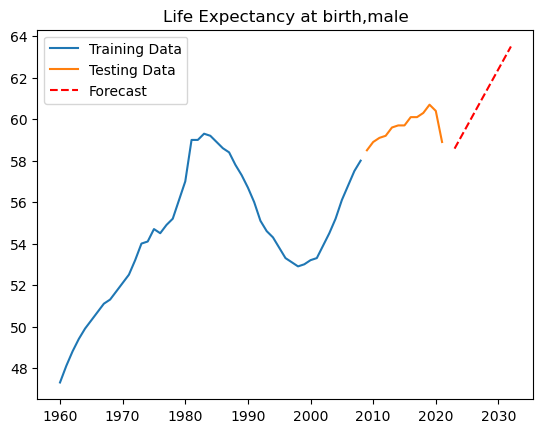

In [17]:
# Plot the original data, training data, and the forecast
plt.plot(train_data.index, train_data['life expectancy at birth,male'], label='Training Data')
plt.plot(test_data.index, test_data['life expectancy at birth,male'], label='Testing Data')
# Plot the forecasted values
plt.plot(forecast_df['Year'], forecast_df['Forecasted_Value'], label='Forecast', color='red', linestyle='dashed')
plt.title('Life Expectancy at birth,male')
plt.legend()
# Save the plot as an image file (e.g., PNG, PDF, SVG)
plt.savefig('male.png', bbox_inches='tight')


In [18]:
dt['life expectancy at birth,male'].describe()

count    62.000000
mean     55.498387
std       3.498079
min      47.300000
25%      53.200000
50%      55.200000
75%      58.900000
max      60.700000
Name: life expectancy at birth,male, dtype: float64

In [19]:
# Combine differenced columns into a single column for modeling
dff = df1['life expectancy at birth,female']
# Convert the Series to a DataFrame with a single column
data2 = dff.to_frame(name='life expectancy at birth,female')
# Print the updated DataFrame
print(data2)

            life expectancy at birth,female
Year                                       
1960-01-01                             50.3
1961-01-01                             51.1
1962-01-01                             51.8
1963-01-01                             52.4
1964-01-01                             52.9
...                                     ...
2017-01-01                             65.0
2018-01-01                             65.2
2019-01-01                             65.3
2020-01-01                             65.1
2021-01-01                             64.1

[62 rows x 1 columns]


In [20]:
# Test statistics for stationarity
# Run both adf and kpss tests
adf_output = adfuller(data2)
kpss_output = kpss(data2)
pd.concat([
    print_results(adf_output, 'adf'),
    print_results(kpss_output, 'kpss')
], axis=1)

,adf,kpss
Test Statistic,-1.900689,0.729378
p-value,0.331737,0.010875
Numbers of lags,2,4
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.546395,0.739
Critical Value (5%),-2.911939,0.463
Critical Value (10%),-2.593652,0.347
Critical Value (2.5%),NaN,0.574


In [21]:
dt1 = data2.reset_index()
dt1.head()

,Year,"life expectancy at birth,female"
0,1960-01-01,50.3
1,1961-01-01,51.1
2,1962-01-01,51.8
3,1963-01-01,52.4
4,1964-01-01,52.9


In [22]:
# Convert 'Year' to datetime type
dt1['Year'] = pd.to_datetime(dt1['Year'], format='%Y')
dt1.set_index('Year', inplace=True)

# Initialize variables to store the best model and its performance
best_model = None
best_rmse = float('inf')

# Define the range of p, d, q values for the grid search
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

# Perform grid search to find the best ARIMA model
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            
            # Fit the ARIMA model
            model = auto_arima(dt1['life expectancy at birth,female'], start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=False, d=1, D=1, trace=False, suppress_warnings=True, stepwise=True)
            model.fit(dt1['life expectancy at birth,female'])
            
            # Make predictions on the test set
            predictions_diff = model.predict(n_periods=len(dt1))
            
            # Calculate RMSE
            rmse = sqrt(mean_squared_error(dt1['life expectancy at birth,female'], predictions_diff))

            # Update the best model if the current model has a lower RMSE
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model

# Print the best model's parameters
print("Best ARIMA Model Parameters:", best_model.order)
# Calculate RMSE
print("Root Mean Squared Error (RMSE) ARIMA:", rmse)

Best ARIMA Model Parameters: (1, 1, 1)
Root Mean Squared Error (RMSE) ARIMA: 5.204928004145742


In [23]:
# Specify the percentage of data for training
train_percentage = 0.8  

# Calculate the index to split the data
split_index = int(len(dt1) * train_percentage)

# Split the data into training and testing sets
train_data1 = dt1.iloc[:split_index]
test_data1 = dt1.iloc[split_index:]

# Print the shapes of the training and testing sets
print("Train shape:", train_data1.shape)
print("Test shape:", test_data1.shape)

Train shape: (49, 1)
Test shape: (13, 1)


In [24]:
# Fit Exponential Smoothing model
model1 = ExponentialSmoothing(test_data1['life expectancy at birth,female'], trend='add')
fit_model1 = model1.fit()
# Make predictions on the test set
predictions_es2 = fit_model1.predict(start=len(train_data1), end=len(train_data1) + len(test_data1) - 1)
# Calculate RMSE
rmse_ex2 = sqrt(mean_squared_error(test_data1, predictions_es2))
print("Root Mean Squared Error (RMSE) Exponential:", rmse_ex2)

Root Mean Squared Error (RMSE) Exponential: 31.146885593362903


In [25]:
# Fit ARIMA model
order = (1, 1, 1)  
model = ARIMA(train_data1['life expectancy at birth,female'], order=order)
fit_model = model.fit()

# Forecast for the next 5 years
forecast_values = fit_model.forecast(steps=10)

# Print the forecast values
print("Forecast for the next 10 years:")
print(forecast_values)


Forecast for the next 10 years:
2009-01-01    61.840104
2010-01-01    62.387091
2011-01-01    62.854505
2012-01-01    63.253922
2013-01-01    63.595235
2014-01-01    63.886896
2015-01-01    64.136128
2016-01-01    64.349103
2017-01-01    64.531096
2018-01-01    64.686613
Freq: AS-JAN, Name: predicted_mean, dtype: float64


In [29]:
# Create a date range for the next 5 years starting from 2021
forecast_years = pd.date_range(start='2022-01-01', periods=len(forecast_values), freq='A')

# Assign the forecasted values to the corresponding years
forecast_df1 = pd.DataFrame({'Year': forecast_years, 'Forecasted_Value': forecast_values.values})

# Print the resulting DataFrame
print(forecast_df1)

        Year  Forecasted_Value
0 2022-12-31         61.840104
1 2023-12-31         62.387091
2 2024-12-31         62.854505
3 2025-12-31         63.253922
4 2026-12-31         63.595235
5 2027-12-31         63.886896
6 2028-12-31         64.136128
7 2029-12-31         64.349103
8 2030-12-31         64.531096
9 2031-12-31         64.686613


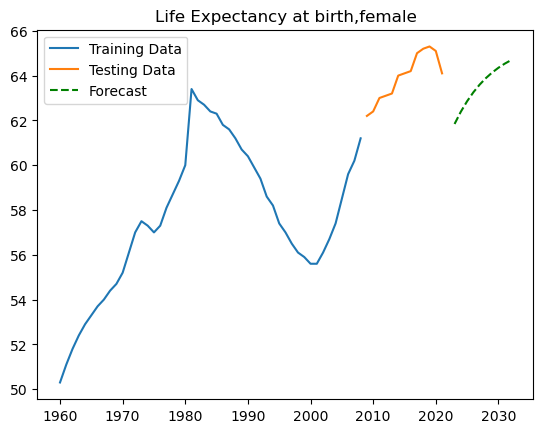

In [27]:
# Plot the original data, training data, and the forecast
plt.plot(train_data1.index, train_data1['life expectancy at birth,female'], label='Training Data')
plt.plot(test_data1.index, test_data1['life expectancy at birth,female'], label='Testing Data')
# Plot the forecasted values
plt.plot(forecast_df1['Year'], forecast_df1['Forecasted_Value'], label='Forecast', color='green', linestyle='dashed')
plt.title('Life Expectancy at birth,female')
plt.legend()
# Save the plot as an image file (e.g., PNG, PDF, SVG)
plt.savefig('female.png', bbox_inches='tight')

In [28]:
data2.describe()

,"life expectancy at birth,female"
count,62.000000
mean,58.908065
std,3.920952
min,50.300000
25%,56.100000
50%,58.650000
75%,62.375000
max,65.300000
